In [1]:
!pip install amplpy pyomo -q
!python -m amplpy.modules install coin highs scip gcg -q

In [2]:

from amplpy import modules
import pyomo.environ as pyo
import pandas as pd
import numpy as np
from pyomo.environ import *


import matplotlib.pyplot as plt
import networkx as nx
import requests



# Caso 1

In [3]:
clientes_data = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Clients.csv")
print(clientes_data.shape)
clientes_data.sample(5)


(24, 5)


,ClientID,LocationID,Product,Longitude,Latitude
23,24,36,11,-74.126293,4.577490
15,16,28,10,-74.111388,4.557321
1,2,14,15,-74.075571,4.687821
13,14,26,15,-74.121920,4.725912
5,6,18,17,-74.120838,4.662137


In [4]:
depositos_data = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Depots.csv")
print(depositos_data.shape)
depositos_data.sample(5)

(12, 4)


,DepotID,LocationID,Longitude,Latitude
10,11,11,-74.109774,4.664703
6,7,7,-74.095619,4.621912
7,8,8,-74.109756,4.678961
5,6,6,-74.124002,4.650463
1,2,2,-74.109934,4.536383


In [5]:
ubicaciones_data = pd.concat([depositos_data[["LocationID","Longitude", "Latitude"]], clientes_data[["LocationID","Longitude", "Latitude"]]], axis = 0)
print(ubicaciones_data.shape)
ubicaciones_data.sample(15)

(36, 3)


,LocationID,Longitude,Latitude
11,12,-74.124089,4.579174
9,10,-74.109916,4.550641
8,21,-74.156153,4.606311
1,14,-74.075571,4.687821
9,22,-74.090411,4.557380
6,19,-74.022131,4.697499
23,36,-74.126293,4.577490
6,7,-74.095619,4.621912
8,9,-74.095472,4.735973
20,33,-74.024549,4.746517


In [6]:
vehiculos = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\case_1_base\Vehicles.csv")
print(vehiculos.shape)
vehiculos.sample(5)

(12, 3)


,VehicleType,Capacity,Range
5,EV,87.102380,906.854049
1,Gas Car,135.544525,195.690896
10,EV,84.450000,1370.460000
9,Gas Car,78.600000,133.130000
7,EV,62.881578,887.542494


In [7]:
vehiculos_data= pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROY2_MOS\Proyecto Seneca Libre\vehicles_data.csv")
print(vehiculos_data.shape)
vehiculos_data.sample(3)

(3, 9)


,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/(gal or kWh)],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficency [kWh/km]
1,Drone,500,500,3000,220.73,2.0,40.0,NaN,0.15
0,Gas Car,5000,500,30000,16000.00,0.1,NaN,10.0,NaN
2,Solar EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15


In [8]:
# DataFrame 2 (datos de vehículos)
vehiculos_data = pd.DataFrame({
    'Vehicle': ['Gas Car', 'EV', 'Drone'],
    'Freight Rate [COP/km]': [5000, 4000, 500],
    'Time Rate [COP/min]': [500, 500, 500],
    'Daily Maintenance [COP/day]': [30000, 21000, 3000],
    'Recharge/Fuel Cost [COP/gal or kWh]': [16000, None, 220.73],
    'Recharge/Fuel Time [min/10 percent charge]': [0.1, None, 2.0],
    'Avg. Speed [km/h]': [None, None, 40.0],
    'Gas Efficiency [km/gal]': [10.0, None, None],
    'Electricity Efficiency [kWh/km]': [None, 0.15, 0.15]
})


# Realizar nuevamente el merge entre los DataFrames
vehiculos_info = vehiculos.merge(vehiculos_data, left_on='VehicleType', right_on='Vehicle', how='left')

vehiculos_info.sample(5)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km]
1,Gas Car,135.544525,195.690896,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN
5,EV,87.102380,906.854049,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
8,EV,76.553642,1062.849467,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
7,EV,62.881578,887.542494,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
9,Gas Car,78.600000,133.130000,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN


In [9]:
num_clientes = 24
clientes_id = RangeSet(1, num_clientes)

In [10]:
num_vehiculos = 12
vehiculos_r = RangeSet(1, num_vehiculos)

In [11]:
num_tipo_v = 2
tipos_vehiculo = RangeSet(1, num_tipo_v)

In [12]:
num_depositos = 12
deposito_origen = RangeSet(1, num_depositos)  # Definir ciudad de origen


In [13]:
num_ubicaciones = num_clientes + num_depositos
ubicaciones = RangeSet(1, num_ubicaciones)


In [14]:
def distancia(coor1, coor2):
    service = "route"
    version = "v1"
    profile = "driving"
    coordinates = f"{coor1[0]},{coor1[1]};{coor2[0]},{coor2[1]}"
    overview = "false"

    url = f"http://router.project-osrm.org/{service}/{version}/{profile}/{coordinates}?alternatives=false&overview={overview}"

    try:
        response = requests.get(url)
    except:
        return np.random.randint(1, 5)
    
    if response.status_code == 200:
        return float(response.json()["routes"][0]["distance"])/1000
    else:
        return 99999

In [15]:
# from concurrent.futures import ThreadPoolExecutor
# def calcular_costos_distancia(num_ubicaciones, ubicaciones_data, ubicaciones):
#     costos_distancia = np.zeros((num_ubicaciones, num_ubicaciones))
#     coor = [(ubicaciones_data["Longitude"].to_numpy()[i - 1], 
#              ubicaciones_data["Latitude"].to_numpy()[i - 1]) for i in ubicaciones]

#     # Función para calcular la distancia para un par específico
#     def calcular_par_distancia(indices):
#         i, j = indices
#         return i, j, distancia(coor[i], coor[j])

#     # Generar todas las combinaciones de índices
#     indices = [(i, j) for i in range(num_ubicaciones) for j in range(num_ubicaciones)]

#     # Usar ThreadPoolExecutor para calcular distancias en paralelo
#     with ThreadPoolExecutor() as executor:
#         resultados = list(executor.map(calcular_par_distancia, indices))

#     # Rellenar la matriz con los resultados
#     for i, j, dist in resultados:
#         costos_distancia[i, j] = dist

#     return costos_distancia

from concurrent.futures import ThreadPoolExecutor
import numpy as np

def calcular_costos_distancia(num_ubicaciones, ubicaciones_data, ubicaciones):
    costos_distancia = np.zeros((num_ubicaciones, num_ubicaciones))
    coor = [(ubicaciones_data["Longitude"].to_numpy()[i - 1], 
             ubicaciones_data["Latitude"].to_numpy()[i - 1]) for i in ubicaciones]

    # Función para calcular la distancia para un par específico
    def calcular_par_distancia(indices):
        i, j = indices
        dist = distancia(coor[i], coor[j])
        return i, j, dist

    # Generar combinaciones solo para i < j
    indices = [(i, j) for i in range(num_ubicaciones) for j in range(i + 1, num_ubicaciones)]

    # Usar ThreadPoolExecutor para calcular distancias en paralelo
    with ThreadPoolExecutor() as executor:
        resultados = list(executor.map(calcular_par_distancia, indices))

    # Rellenar la matriz con los resultados y aprovechar la simetría
    for i, j, dist in resultados:
        costos_distancia[i, j] = dist
        costos_distancia[j, i] = dist  # Copiar el valor simétrico

    return costos_distancia


In [16]:
costos_distancia = calcular_costos_distancia(num_ubicaciones, ubicaciones_data, ubicaciones)
costos_distancia

array([[ 0.    , 33.0616, 10.1619, ..., 20.3231, 12.7272, 26.4218],
       [33.0616,  0.    , 34.1815, ..., 14.3162, 31.4658, 11.1634],
       [10.1619, 34.1815,  0.    , ..., 25.7292, 26.2725, 32.2729],
       ...,
       [20.3231, 14.3162, 25.7292, ...,  0.    , 17.7195,  8.3019],
       [12.7272, 31.4658, 26.2725, ..., 17.7195,  0.    , 23.0588],
       [26.4218, 11.1634, 32.2729, ...,  8.3019, 23.0588,  0.    ]])

In [17]:
def duracion(coor1, coor2):
    service = "route"
    version = "v1"
    profile = "driving"
    coordinates = f"{coor1[0]},{coor1[1]};{coor2[0]},{coor2[1]}"
    overview = "false"

    url = f"http://router.project-osrm.org/{service}/{version}/{profile}/{coordinates}?alternatives=false&overview={overview}"

    try:
        response = requests.get(url)
    except:
        return np.random.randint(1, 5)
    
    if response.status_code == 200:
        return float(response.json()["routes"][0]["duration"])/60
    else:
        return 99999

In [18]:
# from concurrent.futures import ThreadPoolExecutor
# def calcular_costos_duracion(num_ubicaciones, ubicaciones_data, ubicaciones):
#     costos_duracion = np.zeros((num_ubicaciones, num_ubicaciones))
#     coor = [(ubicaciones_data["Longitude"].to_numpy()[i - 1], 
#              ubicaciones_data["Latitude"].to_numpy()[i - 1]) for i in ubicaciones]

#     # Función para calcular la duracion para un par específico
#     def calcular_par_duracion(indices):
#         i, j = indices
#         return i, j, duracion(coor[i], coor[j])

#     # Generar todas las combinaciones de índices
#     indices = [(i, j) for i in range(num_ubicaciones) for j in range(num_ubicaciones)]

#     # Usar ThreadPoolExecutor para calcular duraciones en paralelo
#     with ThreadPoolExecutor() as executor:
#         resultados = list(executor.map(calcular_par_duracion, indices))

#     # Rellenar la matriz con los resultados
#     for i, j, dura in resultados:
#         costos_duracion[i, j] = dura

#     return costos_duracion

from concurrent.futures import ThreadPoolExecutor
def calcular_costos_duracion(num_ubicaciones, ubicaciones_data, ubicaciones):
    costos_duracion = np.zeros((num_ubicaciones, num_ubicaciones))
    coor = [(ubicaciones_data["Longitude"].to_numpy()[i - 1], 
             ubicaciones_data["Latitude"].to_numpy()[i - 1]) for i in ubicaciones]

    # Función para calcular la duracion para un par específico
    def calcular_par_duracion(indices):
        i, j = indices
        return i, j, duracion(coor[i], coor[j])

    # Generar combinaciones solo para i < j
    indices = [(i, j) for i in range(num_ubicaciones) for j in range(i + 1, num_ubicaciones)]

    # Usar ThreadPoolExecutor para calcular duraciones en paralelo
    with ThreadPoolExecutor() as executor:
        resultados = list(executor.map(calcular_par_duracion, indices))

    # Rellenar la matriz con los resultados
    for i, j, dura in resultados:
        costos_duracion[i, j] = dura
        costos_duracion[j, i] = dura   

    return costos_duracion

In [19]:
costos_duracion = calcular_costos_duracion(num_ubicaciones, ubicaciones_data, ubicaciones)
costos_duracion

array([[ 0.        , 41.80333333, 17.565     , ..., 22.61166667,
        14.245     , 33.59      ],
       [41.80333333,  0.        , 42.285     , ..., 20.86      ,
        37.285     , 14.145     ],
       [17.565     , 42.285     ,  0.        , ..., 34.08333333,
        30.06666667, 44.77333333],
       ...,
       [22.61166667, 20.86      , 34.08333333, ...,  0.        ,
        19.35833333, 12.47333333],
       [14.245     , 37.285     , 30.06666667, ..., 19.35833333,
         0.        , 29.95833333],
       [33.59      , 14.145     , 44.77333333, ..., 12.47333333,
        29.95833333,  0.        ]])

In [20]:
from pyomo.environ import *
import pandas as pd
import numpy as np

In [21]:
model = pyo.ConcreteModel()

In [22]:
# Eliminar los componentes existentes antes de redefinirlos
if "N" in model.component_map():
    model.del_component("N")
if "C" in model.component_map():
    model.del_component("C")
if "D" in model.component_map():
    model.del_component("D")

In [23]:
model.C = Set(initialize=clientes_data['LocationID'].tolist())  # Clientes
model.D = Set(initialize=depositos_data['LocationID'].tolist())  # Depósitos
vehiculos_info["Vehicle_ID"] = vehiculos_info.index.astype(int)  # Crear un identificador único si no existe
model.V = Set(initialize=vehiculos_info["Vehicle_ID"].tolist())
model.N = Set(initialize=list(model.C) + list(model.D)) # Nodos



In [24]:
vehiculos_info.sample(5)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km],Vehicle_ID
7,EV,62.881578,887.542494,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,7
11,Gas Car,131.920000,145.850000,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,11
2,Gas Car,114.380319,142.975891,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,2
1,Gas Car,135.544525,195.690896,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,1
10,EV,84.450000,1370.460000,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,10


In [25]:
print("Clientes:", model.C.pprint())
print("Depósitos:", model.D.pprint())
print("Nodos (N):", model.N.pprint())
print("Vehículos:", model.V.pprint())


C : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   24 : {13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}
Clientes: None
D : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   12 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Depósitos: None
N : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   36 : {13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Nodos (N): None
V : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   12 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Vehículos: None


In [26]:
vehiculos_info.sample(10)

,VehicleType,Capacity,Range,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/gal or kWh],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficiency [kWh/km],Vehicle_ID
3,Gas Car,157.901108,173.023042,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,3
2,Gas Car,114.380319,142.975891,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,2
11,Gas Car,131.920000,145.850000,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,11
6,EV,100.645676,617.343951,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,6
1,Gas Car,135.544525,195.690896,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,1
4,EV,86.986092,1108.512009,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,4
5,EV,87.102380,906.854049,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,5
0,Gas Car,131.921140,145.852071,Gas Car,5000,500,30000,16000.0,0.1,NaN,10.0,NaN,0
8,EV,76.553642,1062.849467,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,8
7,EV,62.881578,887.542494,EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15,7


In [27]:
# Parámetros ajustados
model.capacity = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Capacity"])))
model.range = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Range"])))
model.cost_per_km = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Freight Rate [COP/km]"])))
model.cost_per_min = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Time Rate [COP/min]"])))
# Parámetro de costo por unidad de carga transportada (por ejemplo, COP por kg)
model.cost_per_load = pyo.Param(initialize=100)


# Demanda por cliente
model.demand = pyo.Param(model.C, initialize=dict(zip(clientes_data["LocationID"], clientes_data["Product"])))

# Costos por distancia
dist_dict = {
    (ubicaciones_data.iloc[i]["LocationID"], ubicaciones_data.iloc[j]["LocationID"]): costos_distancia[i, j]
    for i in range(num_ubicaciones)
    for j in range(num_ubicaciones)
    if i != j
}

model.distances = pyo.Param(model.N, model.N, initialize=dist_dict, default=0)

# Costos por duración
dura_dict = {
    (ubicaciones_data.iloc[i]["LocationID"], ubicaciones_data.iloc[j]["LocationID"]): costos_duracion[i, j]
    for i in range(num_ubicaciones)
    for j in range(num_ubicaciones)
    if i != j
}

model.durations = pyo.Param(model.N, model.N, initialize=dura_dict, default=0)

# Costo de mantenimiento diario de cada vehículo
model.maintenance_cost = pyo.Param(model.V, initialize=dict(zip(vehiculos_info["Vehicle_ID"], vehiculos_info["Daily Maintenance [COP/day]"])))


In [28]:
del model.x
del model.u
del model.v_use
del model.carga

AttributeError: 'ConcreteModel' object has no attribute 'x'

In [29]:
# Variables binarias para rutas
model.x = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary)

# Variable auxiliar para el orden de visita
model.u = pyo.Var(model.V, model.C, within=pyo.NonNegativeIntegers)

# Varaible auxiliar para saber si un vehículo es utilizado
model.v_use = pyo.Var(model.V, within=pyo.Binary)

# Variable que controla la carga que lleva cada vehiculo
model.carga = pyo.Var(model.N, model.N, model.V, domain=pyo.NonNegativeReals)


In [30]:
if "objective" in model.component_map():
    model.del_component("objective")

In [31]:
# Función objetivo ajustada
def objective_rule(model):
    # Costo por distancia recorrida
    cost_distance = sum(model.cost_per_km[v] * model.distances[i, j] * model.x[i, j, v]
                        for v in model.V for i in model.N for j in model.N if i != j)
    
    # Costo por duración del trayecto
    cost_duration = sum(model.cost_per_min[v] * model.durations[i, j] * model.x[i, j, v]
                        for v in model.V for i in model.N for j in model.N if i != j)
    
    # Costos de mantenimiento
    cost_maintenance = sum(model.maintenance_cost[v] * model.v_use[v] for v in model.V)       
    # Costos de carga
    cost_load = sum(model.cost_per_load* model.capacity[v] * model.v_use[v] for v in model.V)
    # Suma total de costos
    return cost_distance + cost_duration + cost_maintenance + cost_load

model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

In [ ]:
# Eliminar restricciones del modelo
del model.visit_once
del model.flow_conservation
del model.satisfy_demand
del model.vehicle_capacity
del model.vehicle_capacity_01
del model.subtour_elimination
del model.return_to_depot
del model.depot_salida
del model.vehicle_used
del model.vehicle_range

In [36]:
#RESTRICCIONES
#Quitar carga load y arreglar la restriccion de capacidad de los vehiculos
# Restricciones de vista una vez
def visit_once_rule(model, i):
    return sum(model.x[i, j, v] for v in model.V for j in model.N if i != j) == 1

model.visit_once = pyo.Constraint(model.C, rule=visit_once_rule)

#Restricción conservación de flujo
def flow_conservation_rule(model, v, i):
    return sum(model.x[i, j, v] for j in model.N if i != j) == sum(model.x[j, i, v] for j in model.N if i != j)

model.flow_conservation = pyo.Constraint(model.V, model.N, rule=flow_conservation_rule)


# Restricción para habilitar la variable auxiliar v_use
def vehicle_used_rule(model, v):
    return model.v_use[v]*len(model.N) >= sum(model.x[i, j, v] for i in model.N for j in model.N if i != j)
model.vehicle_used = pyo.Constraint(model.V, rule=vehicle_used_rule)

#Restrcción de rango
def vehicle_range_rule(model, v):
    return sum(model.distances[i, j]*model.x[i, j, v] for i in model.N for j in model.N if i != j) <= model.range[v]
model.vehicle_range = pyo.Constraint(model.V, rule=vehicle_range_rule)

#Restricción salida de deposito
def depot_salida_rule(model, v):
    return sum(model.x[d, j, v] for d in model.D for j in model.C) == 1
model.depot_salida = pyo.Constraint(model.V, rule=depot_salida_rule)


# Restricción para garantizar que los vehículos regresen al depósito de salida
def return_to_depot_rule(model, v, d):
    return sum(model.x[d, j, v] for j in model.N if j != d) == sum(model.x[j, d, v] for j in model.N if j != d)

model.return_to_depot = pyo.Constraint(model.V, model.D, rule=return_to_depot_rule)

# Restricción de capacidad de los vehículos
def vehicle_capacity_rule(model, v):
    return sum(model.demand[i]*model.x[i, j, v] for i in model.C for j in model.N if i != j) <= model.capacity[v]

model.vehicle_capacity_01 = pyo.Constraint(model.V, rule=vehicle_capacity_rule)

# Restricción de capacidad de los vehículos
def vehicle_capacity_rule(model, i, j, v):
    return model.carga[i, j, v] <= model.capacity[v] * model.x[i, j, v]
model.vehicle_capacity = pyo.Constraint(model.N, model.N, model.V, rule=vehicle_capacity_rule)

# Restricción para satisfacer la demanda de cada cliente
def satisfy_demand_rule(model, i):
    return sum(model.carga[i, j, v] for j in model.N for v in model.V if j != i) == model.demand[i]
model.satisfy_demand = pyo.Constraint(model.C, rule=satisfy_demand_rule)


# Restricción de subtour elimination (MTZ)
def subtour_elimination_rule(model, v, i, j):
    if i != j and i not in model.D and j not in model.D:  # Aplica a nodos diferentes
        return model.u[v, i] - model.u[v, j] + len(model.C) * model.x[i, j, v] <= len(model.C) - 1
    else:
        return pyo.Constraint.Skip

model.subtour_elimination = pyo.Constraint(model.V, model.C, model.C, rule=subtour_elimination_rule)


In [37]:
class ModelSolver:
    def __init__(self, model):
        self.model = model

    def solve_model(self):
        # Definir el solver
        solver_name = "highs"  # Asegúrate de tener este solver instalado y disponible
        solver = pyo.SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solver_io="nl")

        # Configurar opciones avanzadas del solver
        solver.options['parallel'] = 'on'  # Habilitar paralelismo
        solver.options['time_limit'] = 3600  # Límite de tiempo (1 hora)
        solver.options['presolve'] = 'on'  # Habilitar preprocesamiento
        solver.options['mip_rel_gap'] = 0.01  # Gap relativo del 1% (para MIP)
        #solver.options['simplex_strategy'] = 1  # Estrategia del método simplex (dual simplex)
        #solver.options['simplex_max_concurrency'] = 8  # Máxima concurrencia para simplex
        #solver.options['mip_min_logging_interval'] = 10  # Intervalo mínimo de logs (10s)
        #solver.options['mip_heuristic_effort'] = 0.2  # Esfuerzo heurístico en 20%

        # Resolver el modelo
        result = solver.solve(self.model, tee=True)
        print(result.solver.status)
        print(result.solver.termination_condition)

        # Verificar el estado de la solución
        if result.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == pyo.TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        # Mostrar el resultado
        print(result)


In [38]:
solver = ModelSolver(model)
solver.solve_model()

HiGHS 1.8.1:   alg:parallel = on
  lim:time = 3600
  pre:solve = on
  mip:gap = 0.01
ok
optimal
Optimal solution found.

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 22848
  Number of variables: 31404
  Sense: unknown
Solver: 
- Status: ok
  Message: HiGHS 1.8.1\x3a optimal solution; objective 1157252.34589729; 2.7581e+06 simplex iterations; 5754 branching nodes; absmipgap=11572.4, relmipgap=0.00999987
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1450.958833694458
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [39]:
for i in model.C:
    entrega_total = sum(pyo.value(model.x[i, j, v]) for j in model.N for v in model.V if j != i)
    print(f"Cliente {i}: Demanda = {model.demand[i]}, Entrega total = {entrega_total}")

Cliente 13: Demanda = 13, Entrega total = 1.0
Cliente 14: Demanda = 15, Entrega total = 1.000000000000001
Cliente 15: Demanda = 12, Entrega total = 0.9999999999999989
Cliente 16: Demanda = 15, Entrega total = 1.0
Cliente 17: Demanda = 20, Entrega total = 1.000000000000001
Cliente 18: Demanda = 17, Entrega total = 1.0
Cliente 19: Demanda = 17, Entrega total = 1.0000000000000013
Cliente 20: Demanda = 20, Entrega total = 1.000000000000001
Cliente 21: Demanda = 20, Entrega total = 1.0
Cliente 22: Demanda = 15, Entrega total = 1.0000000000000007
Cliente 23: Demanda = 17, Entrega total = 0.9999999999999998
Cliente 24: Demanda = 12, Entrega total = 1.000000000000002
Cliente 25: Demanda = 21, Entrega total = 0.9999999999999987
Cliente 26: Demanda = 15, Entrega total = 1.0000000000000007
Cliente 27: Demanda = 17, Entrega total = 1.0
Cliente 28: Demanda = 10, Entrega total = 1.0
Cliente 29: Demanda = 25, Entrega total = 1.0
Cliente 30: Demanda = 12, Entrega total = 1.0
Cliente 31: Demanda = 11, 

In [40]:
for v in model.V:
    entrega_total = sum(pyo.value(model.carga[i, j, v]) for i in model.N for j in model.N  if j != i)
    print(f"Vehiculo {v}: Capacidad = {model.capacity[v]}, Capacidad asignada = {entrega_total}")

Vehiculo 0: Capacidad = 131.9211396722696, Capacidad asignada = 10.0
Vehiculo 1: Capacidad = 135.54452491441663, Capacidad asignada = 20.0
Vehiculo 2: Capacidad = 114.38031900663994, Capacidad asignada = 11.0
Vehiculo 3: Capacidad = 157.9011075721774, Capacidad asignada = 25.0
Vehiculo 4: Capacidad = 86.98609179004892, Capacidad asignada = 69.00000000000014
Vehiculo 5: Capacidad = 87.10238029800072, Capacidad asignada = 57.00000000000005
Vehiculo 6: Capacidad = 100.64567561406786, Capacidad asignada = 14.999999999999986
Vehiculo 7: Capacidad = 62.88157761574977, Capacidad asignada = 29.000000000000014
Vehiculo 8: Capacidad = 76.55364248957906, Capacidad asignada = 38.99999999999984
Vehiculo 9: Capacidad = 78.6, Capacidad asignada = 45.0
Vehiculo 10: Capacidad = 84.45, Capacidad asignada = 42.0
Vehiculo 11: Capacidad = 131.92, Capacidad asignada = 15.00000000000003


Rutas seleccionadas para el viajero 0: [(10, 28), (28, 10)]
Rutas seleccionadas para el viajero 1: [(5, 21), (21, 5)]
Rutas seleccionadas para el viajero 2: [(12, 36), (36, 12)]
Rutas seleccionadas para el viajero 3: [(5, 29), (29, 5)]
Rutas seleccionadas para el viajero 4: [(9, 15), (15, 35), (24, 9), (26, 32), (32, 24), (35, 26)]
Rutas seleccionadas para el viajero 5: [(5, 23), (17, 20), (20, 5), (23, 17)]
Rutas seleccionadas para el viajero 6: [(4, 14), (14, 4)]
Rutas seleccionadas para el viajero 7: [(6, 30), (18, 6), (30, 18)]
Rutas seleccionadas para el viajero 8: [(7, 34), (25, 7), (34, 25)]
Rutas seleccionadas para el viajero 9: [(7, 27), (13, 16), (16, 7), (27, 13)]
Rutas seleccionadas para el viajero 10: [(4, 19), (19, 31), (31, 33), (33, 4)]
Rutas seleccionadas para el viajero 11: [(10, 22), (22, 10)]


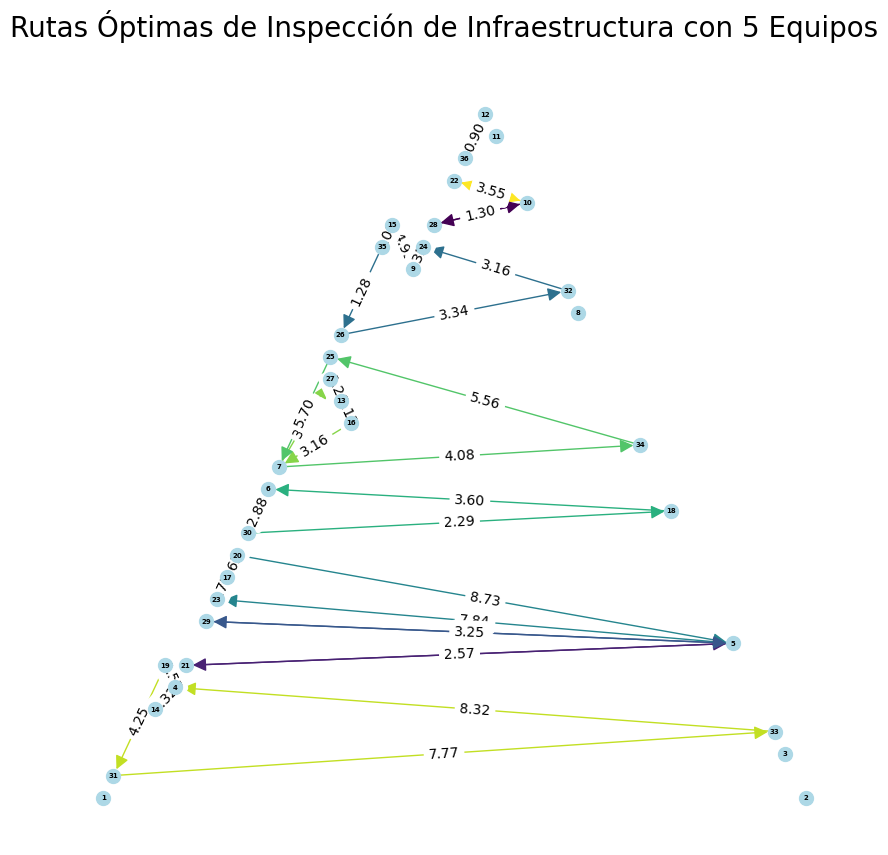

{1: array([-0.72030921, -0.3886156 ]),
 2: array([ 1.       , -0.3886156]),
 3: array([ 0.94940267, -0.33801827]),
 4: array([-0.54321855, -0.26212228]),
 5: array([ 0.82290935, -0.21152495]),
 6: array([-0.31553057, -0.03443429]),
 7: array([-0.2902319 , -0.00913563]),
 8: array([0.44342937, 0.16795502]),
 9: array([0.03865074, 0.21855235]),
 10: array([0.31693605, 0.29444835]),
 11: array([0.24104006, 0.37034434]),
 12: array([0.21574139, 0.39564301]),
 13: array([-0.13843992,  0.06676037]),
 14: array([-0.59381588, -0.28742094]),
 15: array([-0.01194659,  0.26914968]),
 16: array([-0.11314125,  0.0414617 ]),
 17: array([-0.41672523, -0.13562895]),
 18: array([ 0.67111736, -0.05973296]),
 19: array([-0.56851722, -0.23682361]),
 20: array([-0.39142656, -0.11033029]),
 21: array([-0.51791989, -0.23682361]),
 22: array([0.1398454 , 0.31974701]),
 23: array([-0.44202389, -0.16092762]),
 24: array([0.0639494 , 0.24385102]),
 25: array([-0.16373858,  0.1173577 ]),
 26: array([-0.13843992, 

In [41]:

# Extraer las rutas seleccionadas
selected_routes = []
for k in model.V:
    routes_for_k = [(i, j) for i in ubicaciones for j in ubicaciones if i != j and round(model.x[i, j, k].value) == 1]
    print(f"Rutas seleccionadas para el viajero {k}: {routes_for_k}")
    selected_routes.append(routes_for_k)

# Crear el grafo usando NetworkX
G = nx.DiGraph()

# Añadir ubicaciones
for i in ubicaciones:
    G.add_node(i)

for k in range(num_vehiculos):
    for route in selected_routes[k]:
        i, j = route
        G.add_edge(i, j, weight=f"{costos_distancia[i-1,j-1]:.2f}",color=k)

# Dibujar el grafo
edges = G.edges()
edge_colors = [G[u][v]['color'] for u, v in edges]
pos = nx.planar_layout(G)  # Usar un layout circular para una visualización clara
labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_weight='bold', arrowsize=20, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Rutas Óptimas de Inspección de Infraestructura con 5 Equipos", size=20)
plt.show()
pos

In [43]:
!pip install folium


   ---------------------------------------- 0.0/108.9 kB ? eta -:--:--
   ----------- --------------------------- 30.7/108.9 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 108.9/108.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Crear un mapa base centrado en la media de las coordenadas
map_center = [clientes_data['Latitude'].mean(), clientes_data['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Crear un marcador de grupo (para agrupar los marcadores cercanos)
marker_cluster = MarkerCluster().add_to(m)

# Agregar los depósitos al mapa
icon_url_d = "https://cdn-icons-png.flaticon.com/512/8072/8072843.png"  # URL de tu icono
icon_d = folium.CustomIcon(icon_url_d, icon_size=(30, 30))  # Usar el icono desde la URL
for _, row in depositos_data.iterrows():
    location_id = row['LocationID']
    latitude = row['Latitude']
    longitude = row['Longitude']
    folium.Marker(
        location=[latitude, longitude],
        popup=f"Depósito {location_id}",
        icon=folium.Icon(color='blue', icon='info-sign')
        #icon=icon_d
    ).add_to(marker_cluster)

# Agregar los clientes al mapa
icon_url_c = "https://e7.pngegg.com/pngimages/148/892/png-clipart-computer-icons-user-symbol-light-client-icon-service-computer.png"  # URL de tu icono
icon_c = folium.Icon(icon_url_d, icon_size=(30, 30))  # Usar el icono desde la URL
for _, row in clientes_data.iterrows():
    location_id = row['LocationID']
    demand = row['Product']
    latitude = row['Latitude']
    longitude = row['Longitude']
    folium.Marker(
        location=[latitude, longitude],
        popup=f"Cliente {location_id}, Demanda: {demand} unidades",
        #icon=folium.Icon(icon_url_c)
        icon=icon_c
    ).add_to(marker_cluster)
    
# Mostrar las rutas recorridas por los vehículos (solución del modelo)
# Suponiendo que model.x[i, j, v] contiene las rutas del vehículo
for v in model.V:
    for i in model.N:
        for j in model.N:
            if round(pyo.value(model.x[i, j, v])) == 1:  # Si el vehículo v viaja de i a j
                # Obtener las coordenadas de los nodos i y j
                lat_i, lon_i = clientes_data.loc[clientes_data['LocationID'] == i, ['Latitude', 'Longitude']].values[0] \
                    if i in clientes_data['LocationID'].values else depositos_data.loc[depositos_data['LocationID'] == i, ['Latitude', 'Longitude']].values[0]
                lat_j, lon_j = clientes_data.loc[clientes_data['LocationID'] == j, ['Latitude', 'Longitude']].values[0] \
                    if j in clientes_data['LocationID'].values else depositos_data.loc[depositos_data['LocationID'] == j, ['Latitude', 'Longitude']].values[0]

                # Crear la línea (camino) entre los nodos i y j
                folium.PolyLine(
                    locations=[(lat_i, lon_i), (lat_j, lon_j)],
                    color='red',  # Color de la línea
                    weight=2.5,   # Grosor de la línea
                    opacity=1      # Opacidad de la línea
                ).add_to(m)

# Mostrar el mapa en Jupyter
m
